<a href="https://colab.research.google.com/github/manjulamishra/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/Manjula_LS_DS1_233_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [0]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [0]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


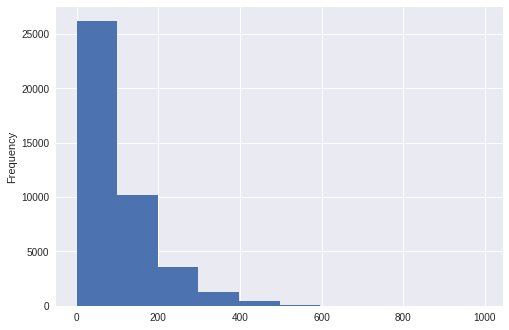

In [0]:
df['pm2.5'].plot.hist();

In [0]:
import numpy as np
df['pm2.5'].dropna().apply(np.log).plot.hist();

ValueError: ignored

In [0]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

In [0]:
','.join(['1', '2', '3'])
# import csv

In [0]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# They can also support * for interaction terms and polynomials
# y ~ x1 + (x1 * x1) + x2 + (x1 * x2)
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Pretend R code

```
ols1 <- lm(y ~ x1 + x2 + (x1 * x1))
summary(ols1)
```

In [0]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [0]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [0]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

import pandas as pd

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00272/SkillCraft1_Dataset.csv')
df.head()

In [0]:
df.shape

In [0]:
df.isna().sum()

In [0]:
import numpy as np
df = df.replace('?', np.nan)
df.isna().sum()

In [0]:
# Quinn's cleaning code
hasna = ['Age', 'HoursPerWeek', 'TotalHours']

for feat in hasna:
   df[feat] = pd.to_numeric(df[feat])
#df[hasna].head()

In [0]:
df.describe()

In [0]:
df.dtypes

In [0]:
# How does linear regression handle it? Courtesy of Daniel
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('APM', axis='columns')
y = df['APM']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

In [0]:
for name, coef in zip(X.columns, linear_reg.coef_):
  print(name, coef)

In [0]:
df.LeagueIndex.value_counts()

In [0]:
# Let's say we want to answer "What are the fastest 10% of SC players like?"
# That means quantile regression with q=0.9

# First we need a formula, with our friend twiddle
quant_formula = 'APM ~ ' + ' + '.join(df.drop('APM', axis='columns').columns)

# From Daniel
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.1)
quant_reg.summary()

In [0]:
quant_reg.predict(X)[:10]

In [0]:
linear_reg.predict(X)[:10]

In [0]:
df.TotalHours.value_counts()

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [0]:
import pandas as pd
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

In [0]:
bwt_df.shape

In [0]:
bwt_df.dtypes

In [0]:
bwt_df.describe()

In [0]:
bwt_df.isna().sum()

In [0]:
import numpy as np
bwt_df = bwt_df.replace('?', np.nan)

In [0]:
bwt_df.shape

In [0]:
bwt_df.columns

In [0]:
#let's do some linear regression
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
#df = df._get_numeric_data().dropna()
X = bwt_df.drop('bwt', axis='columns')
y = bwt_df['bwt']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

In [0]:
bwt_df.bwt.plot.hist();

In [0]:
bwt_df.bwt.quantile(.065)
#df.field_A.quantile(0.1)

In [0]:
y = bwt_df.bwt.quantile(np.linspace(.00001, .90), 'lower')

In [0]:
y.describe()

In [178]:
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke,age_per_weight
0,120,284,0,27,62,100,0,0.270000
1,113,282,0,33,64,135,0,0.244444
2,128,279,0,28,64,115,1,0.243478
3,108,282,0,23,67,125,1,0.184000
4,136,286,0,25,62,93,0,0.268817


In [0]:
#Since we already know what weight is our target, we can calculate the percentile like below
from scipy import stats
q = stats.percentileofscore(bwt_df.bwt, 90)/100

In [159]:
q

0.05664395229982964

In [133]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# They can also support * for interaction terms and polynomials
# y ~ x1 + (x1 * x1) + x2 + (x1 * x2)
# Also, these formulas break with . in variable name, so lets change that
#df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.94)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight + smoke + age_per_weight


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1184
Model:                       QuantReg   Bandwidth:                       5.977
Method:                 Least Squares   Sparsity:                        133.7
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        23:18:28   Df Residuals:                     1166
                                        Df Model:                            7
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -51.9883     53.132     -0.978      0.328    -156.233      52.256
gestation          0.3868      0.086      4.479      0.000       0.217       0.556
parity            -4.3923      2.290     -1.918      0.055      -8.886       0.101
age                0.0337      0.884      0.038      0.970      -1.700       1.767
height             1.0490      0.539      1.948      0.052      -0.008       2.106
weight             0.1556      0.181      0.862      0.389      -0.199       0.510
smoke             -6.6506      1.985     -3.351      0.001     -10.544      -2.757
age_per_weight    15.9097    116.986      0.136      0.892    -213.617     245.437
==================================================================================

The condition number is large, 3.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [0]:
bwt_df['age_per_weight'] = np.divide(bwt_df.age, bwt_df.weight)

In [146]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.056)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight + smoke + age_per_weight


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2047
Model:                       QuantReg   Bandwidth:                       6.323
Method:                 Least Squares   Sparsity:                        118.3
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        23:32:31   Df Residuals:                     1166
                                        Df Model:                            7
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -14.4437     34.847     -0.414      0.679     -82.814      53.927
gestation          0.4555      0.079      5.780      0.000       0.301       0.610
parity            -2.5419      1.979     -1.284      0.199      -6.426       1.342
age                1.9046      0.686      2.776      0.006       0.559       3.251
height             0.9281      0.382      2.431      0.015       0.179       1.677
weight            -0.5278      0.124     -4.254      0.000      -0.771      -0.284
smoke             -9.2266      1.634     -5.646      0.000     -12.433      -6.020
age_per_weight  -264.3397     83.748     -3.156      0.002    -428.653    -100.026
==================================================================================

The condition number is large, 3.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [147]:
quantiles = (.056, .5, .9)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.2047
Model:                       QuantReg   Bandwidth:                       6.323
Method:                 Least Squares   Sparsity:                        118.3
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        23:32:35   Df Residuals:                     1166
                                        Df Model:                            7
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -14.4437     34.847     -0.414      0.679     -82.814      53.927
gestation          0.4555      0.079      5.780      0.000       0.301       0.610
parity            -2.5419      1.979     -1.284      0.199      -6.426       1.342
age                1.9046      0

In [140]:
quant_formula = 'bwt ~ gestation + smoke'
quant_mod = smf.quantreg(quant_formula, data=bwt_df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

(0.5, 0.10575567098777128)
(0.51, 0.1050425249453083)
(0.52, 0.10440217506067861)
(0.53, 0.10360081003516208)
(0.54, 0.10268038384153444)
(0.55, 0.10178135923430975)
(0.56, 0.10099102528829607)
(0.57, 0.09972660278823287)
(0.58, 0.09905328146562176)
(0.59, 0.09811607063741745)
(0.6, 0.09736855167033076)
(0.61, 0.09673848951401154)
(0.62, 0.09577512033361546)
(0.63, 0.09524051532101674)
(0.64, 0.0940083599217888)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.65, 0.09331971300729847)
(0.66, 0.0919336596606175)
(0.67, 0.09100086675597108)
(0.68, 0.08986389407033446)
(0.69, 0.08855389571649874)
(0.7, 0.0873916586855652)
(0.71, 0.08577680115377051)
(0.72, 0.08474926122339965)
(0.73, 0.08327837504352431)
(0.74, 0.08222723144083055)
(0.75, 0.08118352808844975)
(0.76, 0.08064559498366841)
(0.77, 0.0798404372464101)
(0.78, 0.07951167990685415)
(0.79, 0.0782955340622079)
(0.8, 0.07729124679193633)
(0.81, 0.07601794106324411)
(0.82, 0.07434451864369251)
(0.83, 0.07259211980783753)
(0.84, 0.0712686348892313)
(0.85, 0.0699427167153952)
(0.86, 0.06854334261648842)
(0.87, 0.06712651748235698)
(0.88, 0.06616483963575515)
(0.89, 0.06485727939245056)
(0.9, 0.06520233213948945)
(0.91, 0.06468442315174971)
(0.92, 0.06413596543882061)
(0.93, 0.06831513365500852)
(0.94, 0.07421524566620408)
(0.95, 0.08106012947029384)
(0.96, 0.08599845544528095)
(0.97, 0.08768079520817873)
(0.98, 0.09242860617095539)
(0.99, 0.11966915149520496)


In [144]:
quant_formula = 'bwt ~ gestation + smoke + height+'
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.056)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + smoke + height


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1922
Model:                       QuantReg   Bandwidth:                       5.998
Method:                 Least Squares   Sparsity:                        137.4
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        23:26:17   Df Residuals:                     1170
                                        Df Model:                            3
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -105.5000     32.244     -3.272      0.001    -168.762     -42.238
gestation      0.5000      0.092      5.414      0.000       0.319       0.681
smoke         -7.5000      1.934     -3.879      0.000     -11.294      -3.706
height         1.0000      0.396      2.527      0.012       0.224       1.776
==============================================================================

The condition number is large, 8.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [164]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html
%matplotlib inline

from __future__ import print_function
import patsy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [179]:
mod = smf.quantreg('bwt ~ gestation', bwt_df)
res = mod.fit(q=.056)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1629
Model:                       QuantReg   Bandwidth:                       6.324
Method:                 Least Squares   Sparsity:                        133.2
Date:                Thu, 24 Jan 2019   No. Observations:                 1174
Time:                        01:00:49   Df Residuals:                     1172
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -50.2904     25.541     -1.969      0.049    -100.401      -0.179
gestation      0.5161      0.091      5.645      0.000       0.337       0.696

The condition number is large, 4.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


In [180]:
quantiles = np.arange(.056, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['gestation']] + \
            res.conf_int().loc['gestation'].tolist()
    
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])

ols = smf.ols('bwt ~ gestation', bwt_df).fit()
ols_ci = ols.conf_int().loc['gestation'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['gestation'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

       q          a         b        lb        ub
0  0.056 -50.290353  0.516129  0.336753  0.695505
1  0.156 -37.000000  0.500000  0.374130  0.625870
2  0.256 -31.000002  0.500000  0.397143  0.602857
3  0.356 -33.764685  0.529412  0.446333  0.612491
4  0.456 -28.684197  0.526316  0.456171  0.596460
5  0.556 -24.666663  0.523810  0.457379  0.590240
6  0.656 -14.499992  0.500000  0.432794  0.567206
7  0.756   0.178564  0.464286  0.383943  0.544629
8  0.856  54.823530  0.294118  0.179012  0.409223
9  0.956  37.969388  0.397959  0.172464  0.623455
{'a': -10.754138914450326, 'b': 0.46655687694921555, 'lb': 0.40664351443120883, 'ub': 0.5264702394672223}


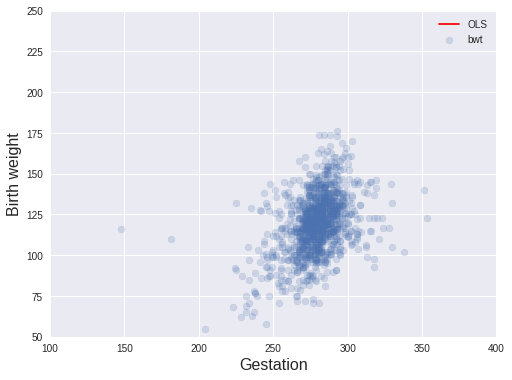

In [188]:
import matplotlib.pyplot as plt
x = np.arange(bwt_df.smoke.min(), bwt_df.smoke.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(bwt_df.gestation, bwt_df.bwt, alpha=.2)
ax.set_xlim((100, 400))
ax.set_ylim((50, 250))
legend = ax.legend()
ax.set_xlabel('Gestation', fontsize=16)
ax.set_ylabel('Birth weight', fontsize=16);

In [0]:
## Quantile regression for the median, 0.5th quantile import pandas as pd  data = pd.DataFram

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model